# CCN Assignment 5: Reinforcement Learning
By: Luca Parolo & Emiel Stoelinga

In the current assignment, several reinforcement learning algorithms will be examined and implemented in a simple environment.

First basic libraries are imported.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from my_env import EvidenceEnv

### Assignment 1
First, an agent is implemented which performs random actions given the observations.

In [2]:
class RandomAgent(object):
    def __init__(self, env):
        """
        Args:
        env: an environment
        """
        self.env = env

    def act(self, observation):
        """
        Act based on observation and train agent on cumulated reward (return)
        :param observation: new observation
        :param reward: reward gained from previous action; None indicates no reward because of initial state
        :return: action (Variable)
        """
#         print(observation)
        action = np.random.choice(self.env.n_action)
#         print(action)
        return action

    def train(self, a, old_obs, r, new_obs):
        """
        :param a: action
        :param old_obs: old observation
        :param r: reward
        :param new_obs: new observation
        :return:
        """
        pass

In [3]:
def run(env, agent, n_iter):
    # reset environment and agent
    obs = env.reset()
    reward = None
    done = False
    R = []
    for step in range(n_iter):
        env.render()
        action = agent.act(obs)
        _obs, reward, done, _ = env.step(action)
        agent.train(action, obs, reward, _obs)
        obs = _obs
        R.append(reward)
        
    return R

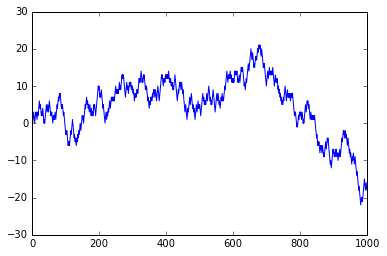

In [4]:
# Number of iterations
n_iter = 1000
# environment specs
env = EvidenceEnv(n=2, p=0.95)
# define agent
rndm_agent = RandomAgent(env)

reward = run(env, rndm_agent, n_iter)
reward_accumulated = np.cumsum(reward)

plt.figure(1)
plt.plot(reward_accumulated)    

In the plot above, accumulated reward of the random agent is represented. What can be seen, is that there is no trend in the reward and that the agent is not learning at all.

### Assignment 2: Q-learning
In the second part of the assignment, a q-learning agent is implemented which predicts the action to chose based on observations and predicted reward.

In [5]:
class QLearnAgent(object):
    def __init__(self, env, alpha, lamb):
        self.env = env
        n_inputs = env.n_input
        n_actions = env.n_action
        self.q_table = np.zeros((2**n_inputs, n_actions))
        
        self.alpha = alpha
        self.lamb = lamb
        
    def act(self, observation):
#         Determine the index of the observation
        idx = self.env.asint(observation)
#         Determine the action with the maximum q-value for the
#         current observation
        action = np.argmax(self.q_table[idx])
        return action
    
    def train(self, a, old_obs, r, new_obs):
#         Determine the index of the observations
        old_idx = self.env.asint(old_obs)
        new_idx = self.env.asint(new_obs)
#         Return the maximum q-value of the new observation 
        fut_q = np.amax(self.q_table[new_idx])
        
#         Compute new q-values using the Bellman equation
        self.q_table[old_idx][a] = self.q_table[old_idx][a]+self.alpha*(r+self.lamb*fut_q-self.q_table[old_idx][a])

2
Table of start q-values
       Action 0  Action 1
[0,0]       0.0       0.0
[0,1]       0.0       0.0
[1,0]       0.0       0.0
[1,1]       0.0       0.0
Table of final q-values
       Action 0  Action 1
[0,0]  7.684119  0.000000
[0,1] -0.800000  6.651996
[1,0]  7.589821  0.000000
[1,1] -0.800000  7.742852


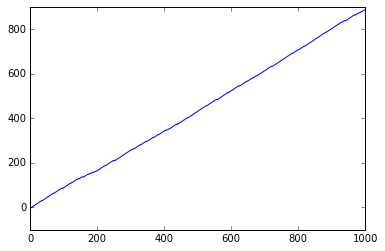

In [6]:
print(env.n_action)
qlearn_agent = QLearnAgent(env, .8, .9)
old_qtable = pd.DataFrame(qlearn_agent.q_table, index=("[0,0]","[0,1]","[1,0]", "[1,1]"), columns=("Action 0", "Action 1"))
print("Table of start q-values")
print(old_qtable)

reward = run(env, qlearn_agent, n_iter)
reward_accumulated = np.cumsum(reward)

plt.figure(2)
plt.plot(reward_accumulated)

new_qtable = pd.DataFrame(qlearn_agent.q_table, index=("[0,0]","[0,1]","[1,0]", "[1,1]"), columns=("Action 0", "Action 1"))

print("Table of final q-values")
print(new_qtable)

What can be seen in the plot above, is that the agent's accumulated reward keeps climbing as the number of epochs grows. There are slight decreases in the increase of accumulated reward, but overall the reward keeps climbing. This is an indication that the system has learned to choose an action based on its q-values.

### Assignment 3
Last, a neural q-agent will be implemented; an MLP that takes observations and learns to 
compute the Q value for all possible actions.

In [7]:
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer import link
from chainer.functions.loss import mean_squared_error
from chainer.functions.evaluation import accuracy
from chainer import reporter


In [8]:
class MLP(Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units)
            self.l2 = L.Linear(None, n_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

In [9]:
class Regressor(link.Chain):

    compute_accuracy = False

    def __init__(self, predictor,
                 lossfun=mean_squared_error.mean_squared_error,
                 accfun=accuracy.accuracy,
                 label_key=-1):
        if not (isinstance(label_key, (int, str))):
            raise TypeError('label_key must be int or str, but is %s' %
                            type(label_key))

        super(Regressor, self).__init__()
        self.lossfun = lossfun
        self.accfun = accfun
        self.y = None
        self.loss = None
        self.accuracy = None
        self.label_key = label_key

        with self.init_scope():
            self.predictor = predictor

    def __call__(self, *args, **kwargs):

        if isinstance(self.label_key, int):
            if not (-len(args) <= self.label_key < len(args)):
                msg = 'Label key %d is out of bounds' % self.label_key
                raise ValueError(msg)
            t = args[self.label_key]
            if self.label_key == -1:
                args = args[:-1]
            else:
                args = args[:self.label_key] + args[self.label_key + 1:]
        elif isinstance(self.label_key, str):
            if self.label_key not in kwargs:
                msg = 'Label key "%s" is not found' % self.label_key
                raise ValueError(msg)
            t = kwargs[self.label_key]
            del kwargs[self.label_key]

        self.y = None
        self.loss = None
        self.accuracy = None
        self.y = self.predictor(*args, **kwargs)
        self.loss = self.lossfun(self.y, t)
        reporter.report({'loss': self.loss}, self)
        return self.loss

In [10]:
from chainer import cuda
from chainer import function
from chainer import utils
from chainer.utils import type_check

class SquaredDifference(function.Function):
    """Squared difference of input variables."""

    def check_type_forward(self, in_types):
        type_check.expect(in_types.size() == 2)
        type_check.expect(
            in_types[0].dtype.kind == 'f',
            in_types[0].dtype == in_types[1].dtype,
            in_types[0].shape == in_types[1].shape
        )

    def forward(self, inputs):
        self.retain_inputs(())
        self._in_dtype = inputs[0].dtype
        xp = cuda.get_array_module(*inputs)
        x1, x2 = inputs
        self.difference = x1 - x2
        y = xp.square(self.difference)
        return utils.force_array(y, dtype=x1.dtype),

    def backward(self, inputs, grads):
        gy, = grads
        gx = gy * 2 * self.difference
        gx = utils.force_array(gx, dtype=self._in_dtype)
        gx_minus = utils.force_array(-gx, dtype=self._in_dtype)
        return gx, gx_minus
    
def squared_difference(x1, x2):
    """Squared difference of input variables.
    Args:
        x1 (~chainer.Variable): Input variables to be compared.
        x2 (~chainer.Variable): Input variables to be compared.
    Returns:
        ~chainer.Variable: ``(x1 - x2) ** 2`` element-wise.
    """
    print("Start.")
    print(x1)
    print(x2)
    output = SquaredDifference()(x1, x2)
    print(output)
    print("Done.")
    return output

In [14]:
class NeuralQAgent(object):
    def __init__(self, lamb):        
        self.lamb = lamb
        
        self.mlp = MLP(10, 2)
        self.regressor = Regressor(self.mlp, F.squared_difference)
        self.optimizer = optimizers.SGD()
        self.optimizer.setup(self.regressor)
        
    def act(self, observation):
        # transform observation into correct dimensions
        observation = np.array([observation])
        
        # compute q-values for all actions
        qvalues = self.mlp(observation).data[0]
        self.mlp.cleargrads()
        
        # choose action with the highest q-value
        if(qvalues[0]>qvalues[1]):
            return 0
        else:
            return 1
    
    def train(self, a, old_obs, r, new_obs):
        # transform observations into correct dimensions
        old_obs = np.array([old_obs])
        new_obs = np.array([new_obs])
        
        # compute q-values for old and new observations
        q_old = self.mlp(old_obs).data[0]
        q_new = self.mlp(new_obs).data[0]
        
        # select the action for the new observation with the highest q-value
        maxa_new = np.amax(q_new)
        idx_maxa_new = np.argmax(q_new)
        
        # initialize target q-values, and
        tgt_q = q_new
        # set the target q-value for action a
        tgt_q[idx_maxa_new] = r+self.lamb*maxa_new
        tgt_q = Variable(np.array([tgt_q]))
        
        # calculate loss and backpropagate
        loss = self.regressor(old_obs, tgt_q)
        if loss.grad == None:
            loss.grad = np.ones_like(loss.data, dtype=loss.data.dtype)
        self.mlp.cleargrads()
        loss.backward()
        self.optimizer.update()

Old q-values.
       Action 0  Action 1
[0,0]  0.000000  0.000000
[0,1] -0.087175  0.082452
[1,0]  0.079574  0.020009
[1,1]  0.098094  0.066372
New q-values.
       Action 0  Action 1
[0,0]  6.530638  6.398492
[0,1]  5.970027  6.202227
[1,0]  5.929813  6.215488
[1,1]  6.373582  6.900719


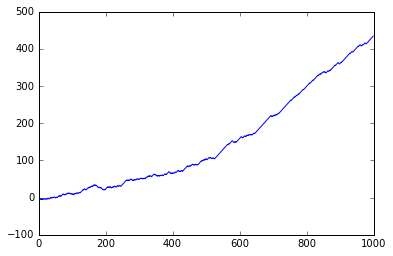

In [66]:
neuralq_agent = NeuralQAgent(.9)
old_qtable = np.empty(shape=(1,2))
old_qtable = np.append(old_qtable, neuralq_agent.mlp(np.array([[0,0]], dtype=np.float32)).data, axis=0)
old_qtable = np.append(old_qtable, neuralq_agent.mlp(np.array([[0,1]], dtype=np.float32)).data, axis=0)
old_qtable = np.append(old_qtable, neuralq_agent.mlp(np.array([[1,0]], dtype=np.float32)).data, axis=0)
old_qtable = np.append(old_qtable, neuralq_agent.mlp(np.array([[1,1]], dtype=np.float32)).data, axis=0)
old_qtable = np.delete(old_qtable, 0, 0)
old_qtable = pd.DataFrame(old_qtable, index=("[0,0]","[0,1]","[1,0]", "[1,1]"), columns=("Action 0", "Action 1"))
print("Old q-values.")
print(old_qtable)

reward = run(env, neuralq_agent, n_iter)
reward_accumulated = np.cumsum(reward)

new_qtable = np.empty(shape=(1,2))
new_qtable = np.append(new_qtable, neuralq_agent.mlp(np.array([[0,0]], dtype=np.float32)).data, axis=0)
new_qtable = np.append(new_qtable, neuralq_agent.mlp(np.array([[0,1]], dtype=np.float32)).data, axis=0)
new_qtable = np.append(new_qtable, neuralq_agent.mlp(np.array([[1,0]], dtype=np.float32)).data, axis=0)
new_qtable = np.append(new_qtable, neuralq_agent.mlp(np.array([[1,1]], dtype=np.float32)).data, axis=0)
new_qtable = np.delete(new_qtable, 0, 0)
new_qtable = pd.DataFrame(new_qtable, index=("[0,0]","[0,1]","[1,0]", "[1,1]"), columns=("Action 0", "Action 1"))
print("New q-values.")
print(new_qtable)
    
plt.figure(3)
plt.plot(reward_accumulated)

As can be seen in the above figure, the network steadily learns. Accumulated reward climbs over the course of time and what is striking to see is that from epoch ~500, the reward seems to climb progressively. This is an indication that the network is actually learning. The predicted q-values also seem to be better estimates of the real q-values. 